# Logistic Regression on Customized Handwritten Digits

In [1]:
import time
import io
import matplotlib.pyplot as plt
import numpy as np
from scipy.io.arff import loadarff

from sklearn.datasets import get_data_home
from sklearn.externals.joblib import Memory
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from urllib.request import urlopen

In [2]:
memory = Memory(get_data_home())
@memory.cache()
def fetch_mnist():
    content = urlopen(
        'https://www.openml.org/data/download/52667/mnist_784.arff').read()
    data, meta = loadarff(io.StringIO(content.decode('utf8')))
    data = data.view([('pixels', '<f8', 784), ('class', '|S1')])
    return data['pixels'], data['class']
X, y = fetch_mnist()

In [3]:
X = X / 255.

###### NEW  Refromat the the labels to be integers rather than byte arrays
y_trans = []
for i in range(len(y)):
    y_trans.append(int(y[i]))
y = np.asarray(y_trans)

X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

In [4]:
## Data standardization
## by the mean and standared deviation of the training set
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [5]:
# Turn up tolerance for faster convergence
clf = LogisticRegression(C=50. / 1000,
                         multi_class='multinomial',
                         penalty='l1', solver='saga', tol=0.1)
# Train the classifier
clf.fit(X_train, y_train)

#Evaluate the classifier
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
# print('Best C % .4f' % clf.C_)
print("Sparsity with L1 penalty: %.2f%%" % sparsity)
print("Test score with L1 penalty: %.4f" % score)

Sparsity with L1 penalty: 15.96%
Test score with L1 penalty: 0.9018


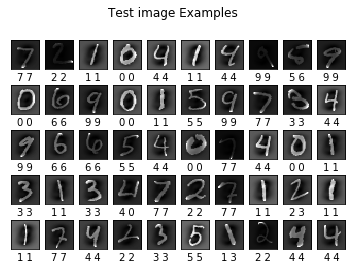

In [6]:
### Bounus 1: show the first 40 images
### ALways a good idea to validate that the data appears as you expect
### 
### for sci-kit learn the images are represented as vectors of 784 elements
### currently scaled from 0 to 1

for i in range(50):
    l1_plot = plt.subplot(5, 10, i + 1)
    l1_plot.imshow(255 * X_test[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.gray)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    #l1_plot.set_xlabel('Class %s' % y_test[i].decode())
    l1_plot.set_xlabel("{} {}".format(y_test[i], y_pred[i]))
plt.suptitle('Test image Examples')
plt.show()

<p>NOTE the left digit represents the correct label; right is the predicted label</p>

## MNIST Test Discussion
<p>Based on this results, the logistic regression model works really well with the MNIST test data set with a test score of 90%. It appears that this model takes into account the various gray level images, as the training and test images are not completely binary.</p>

In [7]:
""" Custom datatset loader
    based on https://github.com/utkuozbulak/pytorch-custom-dataset-examples
"""
import pandas as pd
import imageio

class SimpleDataset():
    def __init__(self, data_path, csv_name, transform = None ):
        """
        Args:
            data_path (string): path to the folder where images and csv files are located
            csv_name (string): name of the csv lablel file
            transform: pytorch transforms for transforms and tensor conversion
        """
        # Set path
        self.data_path = data_path
        # Read the csv file
        self.data_info = pd.read_csv(data_path + csv_name, header=None)
        # First column contains the image paths
        self.image_arr = np.asarray(self.data_info.iloc[:, 0])
        # Second column is the labels
        self.label_arr = np.asarray(self.data_info.iloc[:, 1])
        # Calculate len
        self.data_len = len(self.data_info.index)
        
    def __getitem__(self, index):
        # Get image name from the pandas df
        single_image_name = self.image_arr[index]
        # Open image
        img_as_img = imageio.imread(self.data_path + single_image_name)
        
        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.label_arr[index]
        
        return (img_as_img, single_image_label)

    def __len__(self):
        return self.data_len

In [8]:
mydata = SimpleDataset( "./idata/", "labels.csv")

#splitting into images and labels 
X = []
y = []
for i in range(len(mydata)):
    X.append(mydata[i][0])
    y.append((mydata[i][1]))

#converting into numpy arrays to enable easy reshaping and other array operations
    
X = np.asarray(X)
print("Shape of the input image", X.shape)
y= np.asarray(y)
print(y.shape)

Shape of the input image (60, 28, 28)
(60,)


In [9]:
#reshaping the array into flattened 784 array as an input for prediciton by the logistic regression classifier
X_test = X.reshape(X.shape[0], 784)
X_test = X_test / 255.
#data standardiation with the training set statistics is required for this clasifier
X_test = scaler.fit_transform(X_test)

y_pred = clf.predict(X_test)

score = clf.score(X_test, y)
print("Test score with L1 penalty: %f" % score)
print("y_predicted_values", y_pred)

Test score with L1 penalty: 0.300000
y_predicted_values [3 7 2 1 5 0 0 0 8 5 7 1 8 4 5 5 1 9 4 8 9 3 1 8 4 4 2 9 2 1 1 2 4 2 4 5 1
 7 9 8 1 1 5 9 8 1 5 1 8 4 7 5 3 1 5 1 1 5 1 1]


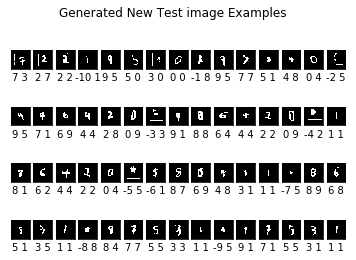

In [10]:
import warnings
warnings.filterwarnings('ignore')
#l1_plot = plt.subplot(1, 4, i + 1)
for i in range(60):
    l1_plot = plt.subplot(4, 15, i + 1)
    l1_plot.imshow(X[i], interpolation='nearest',
                   cmap=plt.cm.gray)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('{} {}'.format(y[i], y_pred[i]))
    
plt.suptitle('Personal Handwrritten Examples')
plt.show()

<p>NOTE: the left digit represents the correct label; right is the predicted label</p>

## Personal Handwritten Discussion
<p> Unlike the MNIST test set, the trained Logistic Regression model works poorly on my handwritten digit with a poor test accuracy of 30%</p>
<p>The model does not seem to take into account many of the imperfections of my data set. For example, the MNIST data isn't completely binarized like mine, nor does there seem to be outstanding artifacts. In addition, some of my images have discountinuities as a result of the downsampling and thresholding. In addition, my set contains non-digit charcters, some of which the original model did not account for. As a result, the predicted labels for these images would never be correct.</p>